# ECS708P mini-project submission

**Zhuoran Li 120720961**

**Summary**

In basic solution, comparing with the given features extraction method from MLEnd_starter_kit, 
I finally choose to use tsfel to extract the features, which is a good package to deal with the time-series signals.
Reference: https://github.com/fraunhoferportugal/tsfel/

For the classifier, I have tried 2 models, namely KNN and SVM. 
After trying to optimize the parameters of both models, 
I finally choose SVM which has the better accuracy in my work.

In advanced solution, I decide to build a model that can identify the numeral.
Most work in this part is similar with the basic part.
I still use TSFEL to extract features and use SVM as the classifier.
The main differences are features selection and parameters of the model.
I use LDA in this part for features selection.

# 1 Basic solution


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os, sys, re, pickle, glob
import urllib.request

from IPython.display import Audio
import IPython.display as ipd
from tqdm import tqdm
import librosa
# drive.mount('/content/drive')

import tsfel ### time series data lib for feature extraction
from collections import Counter
from sklearn.feature_selection import VarianceThreshold
from sklearn import preprocessing
from sklearn import metrics
from sklearn.metrics import confusion_matrix
# from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

Because running this project on google colab is inefficient, **I did all of my work in my local environment**.

**That's why all the paths in this notebook are local paths.**

**Data preparation**

**Preprocessing**

**Visualization**

,File ID,digit_label,participant,intonation
0,0000000.wav,4,S73,question
1,0000001.wav,2,S88,excited
2,0000002.wav,70,S5,neutral
3,0000003.wav,2,S85,bored
4,0000004.wav,4,S30,excited
...,...,...,...,...
19995,0019995.wav,90,S163,excited
19996,0019996.wav,10,S99,question
19997,0019997.wav,90,S46,question
19998,0019998.wav,19,S13,neutral


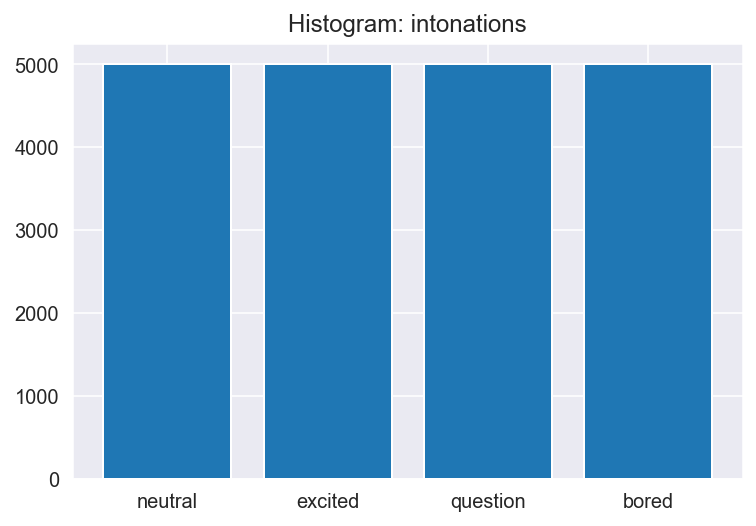

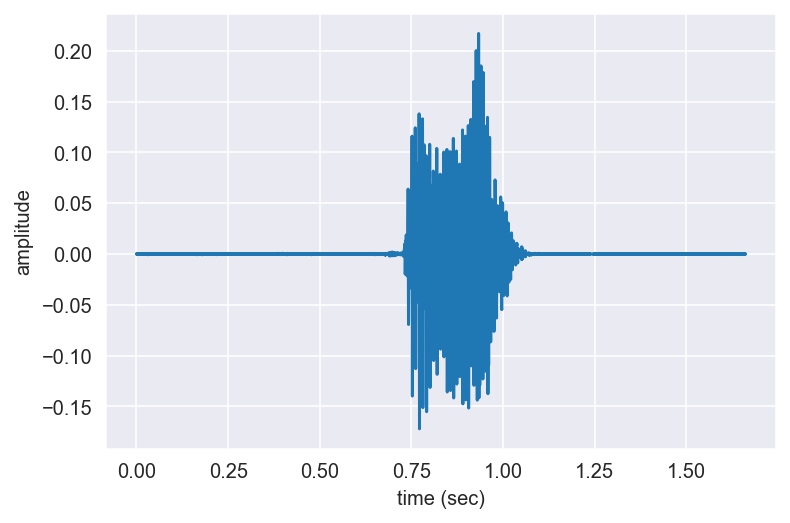

In [ ]:
# Data preparation

files = glob.glob('D:/MLEnd/Training/*.wav') #the audio files
len(files)
# five random files
for _ in range(5):
  n = np.random.randint(20000)
  display(ipd.Audio(files[n]))
    
labels = pd.read_csv('D:/MLEnd/trainingMLEnd.csv')
labels = labels.dropna() #data preprocessing: remove the rows that have missing values
display(labels)

# This file consists of 20k rows and 4 columns. Each row corresponds to one of the items in our dataset, and each item is described by four attributes:

# File ID (audio file)
# Numeral
# Participand ID
# Intonation
intonation_count = labels['intonation'].value_counts()

#visualization

# show the distribution of the data in terms of intonations
plt.bar(intonation_count.index,intonation_count)
plt.title('Histogram: intonations')
plt.show()

#show a waveform of an example in our audio files
n=0
fs = None # Sampling frequency. If None, fs would be 22050
x, fs = librosa.load(files[n],sr=fs)
t = np.arange(len(x))/fs
plt.plot(t,x)
plt.xlabel('time (sec)')
plt.ylabel('amplitude')
plt.show()
display(ipd.Audio(files[n]))

**Features extraction**

Most of explanations I write beside the codes as comments



**Given features**

In [ ]:
#Features extraction

#option 1. the given method. It defines a function to extrach 4 features, namely 
# Power.
# Pitch mean.
# Pitch standard deviation.
# Fraction of voiced region.

# the function that gets the pitch of an audio signal:
def getPitch(x,fs,winLen=0.02):
  #winLen = 0.02 
  p = winLen*fs
  frame_length = int(2**int(p-1).bit_length())
  hop_length = frame_length//2
  f0, voiced_flag, voiced_probs = librosa.pyin(y=x, fmin=80, fmax=450, sr=fs,
                                                 frame_length=frame_length,hop_length=hop_length)
  return f0,voiced_flag

# the function that takes a number of files and creates a NumPy array containing the 4 audio features
# used as predictors (X) and their labels (y).
def getXy(files,labels_file,scale_audio=False, onlySingleDigit=False):
  X,y =[],[]
  for file in tqdm(files):
    fileID = file.split('/')[-1]
    yi = list(labels_file[labels_file['File ID']==fileID]['intonation'])[0]
    
    fs = None # if None, fs would be 22050
    x, fs = librosa.load(file,sr=fs)
    if scale_audio: x = x/np.max(np.abs(x))
    f0, voiced_flag = getPitch(x,fs,winLen=0.02)

    power = np.sum(x**2)/len(x)
    pitch_mean = np.nanmean(f0) if np.mean(np.isnan(f0))<1 else 0
    pitch_std  = np.nanstd(f0) if np.mean(np.isnan(f0))<1 else 0
    voiced_fr = np.mean(voiced_flag)

    xi = [power,pitch_mean,pitch_std,voiced_fr]
    X.append(xi)
    y.append(yi)
  return np.array(X),np.array(y)

##Result: I use this method to extract features to fit the svm model. After tunning, the best result for my model is:
# Training data size: 16000
# Validation data size: 4000
# Best score: 0.461
# Best parameters set:
# 	C: 1
# 	gamma: 'auto'
# 	kernel: 'rbf'
# Training Accuracy 0.647
# Validation  Accuracy 0.47

#This result doesn't make me satisfied, so I try the other method to extract features.

**TSFEL**

In [ ]:
# option 2. TSFEL
# TSFEL is optimized for time series and automatically extracts over 60 different features
# on the statistical, temporal and spectral domains.
# see https://github.com/fraunhoferportugal/tsfel/ to find the concrete features in each domain

def feature_extraction(data_fe, fs):
  cfg = tsfel.get_features_by_domain()
  features = tsfel.time_series_features_extractor(cfg, data_fe, fs=fs)
# Preprocessing: replace the outliers and missing values with the median
  features.replace([np.inf, -np.inf], np.nan, inplace=True)
  features.fillna(features.median(), inplace=True)
  return features

#select features from which we extracted
# Firstly I write some codes to save the extracted data into a csv file so that I do not need to load the features every time I do test
## when I use different number of samples to test, this file can be also updated.
def features_selection(data, fs):

    if os.path.exists("D:/MLEnd/train_features_tsfel.csv"):
        train = pd.read_csv(r'D:/MLEnd/train_features_tsfel.csv') # loading the train data
        train = train.drop("Unnamed: 0", axis= 1)
        print('Trained features loaded!')
    else:
        train = feature_extraction(data, fs)
        train = pd.DataFrame(train)
        train.to_csv("D:/MLEnd/train_features_tsfel.csv")

    if train.shape[0] != data.shape[0]:
        train = feature_extraction(data, fs)
        train = pd.DataFrame(train)
        train.to_csv("D:/MLEnd/train_features_tsfel.csv")


    # feature selection
    
    # Remove low variance features
    selector = VarianceThreshold()
    train = selector.fit_transform(train)

    #normalizing the features data
    scaler = preprocessing.StandardScaler()
    scaler.fit(train)
    train = scaler.transform(train)
#     train.to_csv("D:/MLEnd/train_features_after_selection.csv")    write out the features after selection to a csv if need

    return train


def getXy(files,labels_file):
    X = [] ### including training features
    y = [] ### including all labels but represent in classes number


    ####### extract x_train as training features using TSFEL
    X_data = []
    for file in tqdm(files):

        fs = None # if None, fs would be 22050
        x, fs = librosa.load(file,sr=fs) #use librosa to load the audio files
        X_data.append(x)
    X_data = np.array(X_data)
    X = features_selection(X_data, fs)

    
    ####### extract y_train
    ## show how intonation map to number of classes using LabelEncoder
    intonation_labels = labels_file['intonation'].to_numpy()
    le = preprocessing.LabelEncoder()
    le.fit(intonation_labels)
    y = le.transform(intonation_labels)
#     classes = le.classes_ ##this is to show the labels' classes
# if you want to inverse the labelencoder, just invoke le.inverse_transform(y)

    return np.array(X),np.array(y)

**Model**

  1%|▏         | 258/20000 [00:00<00:07, 2579.98it/s]

In total file length 20000


100%|██████████| 20000/20000 [00:07<00:00, 2748.77it/s]
<ipython-input-41-43b2a001c799>:61: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  X_data = np.array(X_data)


Trained features loaded!
0
Training data size: 16000
Validation data size: 4000
Best score: 0.668
Best parameters set:
	C: 100
	gamma: 'auto'
	kernel: 'rbf'
MAE: 0.541
Training Accuracy 0.8895625
Validation  Accuracy 0.685
[[3548   31  319   94]
 [  55 3603  154  198]
 [ 278   98 3487  166]
 [ 103  116  155 3595]]
[[757  44 151  56]
 [ 48 687  86 169]
 [133  97 627 114]
 [ 80 179 103 669]]


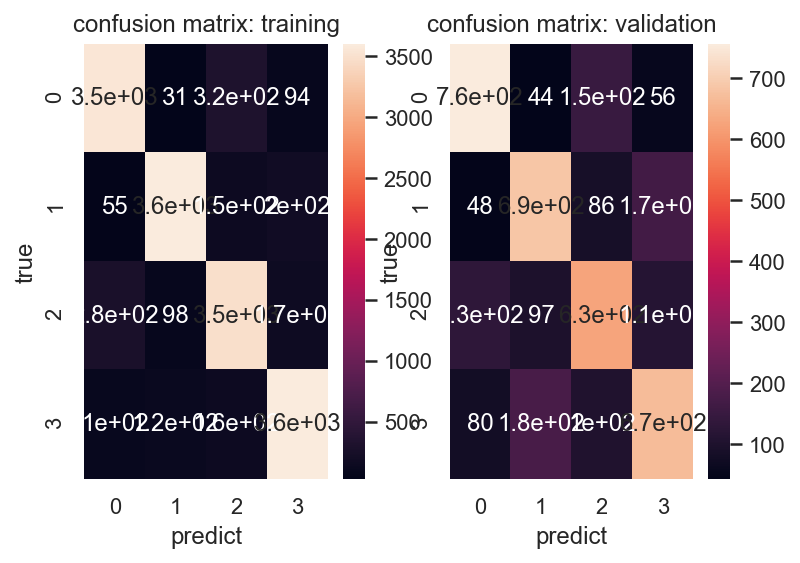

In [ ]:
def main():
#For easier to do test with different number of samples
    DEBUG = True
    number_of_sample = 20000

    ##### check out what's in the dataset
    ##I sort the audio files so that they are in sequence from 0-19999 to match the labels' sequence in trainingMLEnd.csv.
    if DEBUG == True:
        files = np.sort(glob.glob('D:/MLEnd/Training/*.wav'))[:number_of_sample]
    else:
        files = np.sort(glob.glob('D:/MLEnd/Training/*.wav'))
    print(f'In total file length {len(files)}')

    ##### Loading label from csv files
    labels = pd.read_csv('D:/MLEnd/trainingMLEnd.csv')

    ###### Get features and labels
    X_all, y_all = getXy(files, labels)

    if DEBUG == True:
        y_all = y_all[:number_of_sample]
        d = Counter(y_all)
        d_s = sorted(d.items(),key=lambda x:x[1],reverse=True)

    # If nan sample, remove them
    if np.sum(np.isnan(X_all)):
        idx = np.isnan(X_all).sum(1)>0
        X_all = X_all[~idx]
        y_all = y_all[~idx]
    print(np.sum(np.isnan(X_all)))


    ## devide all data to training and validation datasets
    from sklearn.model_selection import train_test_split
    #shuffle is True to make sure we split the dataset randomly
    X_train, X_val, y_train, y_val = train_test_split(X_all,y_all,test_size=0.2, shuffle=True)
    print(f'Training data size: {X_train.shape[0]}')
    print(f'Validation data size: {X_val.shape[0]}')


    
    
    ######## Classifiers
    
#     1. At first I try the KNN model. I use different k between 1 and 20 to fit my data
#     and the best model is n_neighbors=3. 
#     I run 5 times and the average result is training accuracy=0.83, validation accracy=0.65

    # from sklearn.neighbors import KNeighborsClassifier
    #
    # for knd in range(20):
    #     print(f'---------K={knd+1}----------')
    #     print('SBP prediction')
    #     modelKNN_sbp = KNeighborsClassifier(n_neighbors= knd+1).fit(X_train, y_train)
    #     yt_p = modelKNN_sbp.predict(X_train)
    #     yv_p = modelKNN_sbp.predict(X_val)
    #     print(f'MAE: {metrics.mean_absolute_error(y_val, yv_p)}')
    #     print('Training Accuracy', np.mean(yt_p==y_train))
    #     print('Validation  Accuracy', np.mean(yv_p==y_val))
    #


    def print_best_score(gsearch,param_test):
         # output best score
        print("Best score: %0.3f" % gsearch.best_score_)
        print("Best parameters set:")
        # display the best parameters this classifier used
        best_parameters = gsearch.best_estimator_.get_params()
        for param_name in sorted(param_test.keys()):
            print("\t%s: %r" % (param_name, best_parameters[param_name]))


#     2. Then I try SVM. I use Grid Search method to try different combinations of these three parameters: kernel, C, gamma:
#     parameters = {
#                     'kernel':['linear', 'poly', 'rbf', 'sigmoid'],
#                     'C':[0.1, 1, 10, 100],
#                     'gamma':['auto',0.0001,0.00001,0.000001],
#                     }
#     I use 4000 samples to run the test and it returns the best parameters: kernel=rbf, C=100, gamma=auto.
#     So I apply these parameters on my final model to run all the 20000 data
#     Also, after running 5 times the result is MAE=0.535, training accuracy=0.89, validation accuracy=0.69

    #### SVM
    from sklearn import svm
    model = svm.SVC()
    parameters = {
                    'kernel':['rbf'],
                    'C':[100],
                    'gamma':['auto'],
                    }

    from sklearn.model_selection import GridSearchCV
    gsearch = GridSearchCV( model , param_grid = parameters, cv=5 )
    gsearch.fit( X_train, y_train)
    # gsearch.grid_scores_, gsearch.best_params_, gsearch.best_score_
    print_best_score(gsearch,parameters)

    #
    yt_p = gsearch.predict(X_train)
    yv_p = gsearch.predict(X_val)

    print(f'MAE: {metrics.mean_absolute_error(y_val, yv_p)}')
    print('Training Accuracy', np.mean(yt_p==y_train))
    print('Validation  Accuracy', np.mean(yv_p==y_val))


    #Visualization: confusion matrix
    sns.set()
    fig, (ax1, ax2) = plt.subplots(1, 2)
    C_train= confusion_matrix(y_train, yt_p, labels=[0, 1, 2, 3])
    C_val= confusion_matrix(y_val, yv_p, labels=[0, 1, 2, 3])
    print(C_train)
    print(C_val)

    sns.heatmap(C_train,annot=True,ax=ax1) #heat map for training set
    sns.heatmap(C_val,annot=True,ax=ax2) ##heat map for validation set
    
    ax1.set_title('confusion matrix: training') #title
    ax1.set_xlabel('predict') #x axis
    ax1.set_ylabel('true') #y axis
    
    ax2.set_title('confusion matrix: validation')
    ax2.set_xlabel('predict')
    ax2.set_ylabel('true')

if __name__ == '__main__':
    main()

#Conclusions:

Comparing the two features extraction methods and two classifiers I tried above, I find that using TSFEL to extract features 
and fit them with a SVM model returns a better result.

When tunning the models, I find that for my extracted features, the best kernel function is 'rbf', which means "Gaussian".

And when I increase the value of the regularization parameter C, the 'rbf' model get a higher accuracy until C=100.

I tried the higher order such as C=1000, however, it got a great improvement on tranning accuracy, but not on validation accuracy.

I think it's overfitting. I also tried the value around 100, however, after tradeoff C=100 is still better for my model.

gamma='auto' get the better result in my model. 'auto' stands for 1/n_features.


My final model is a SVM classifier with parameters kernel='rbf', C=100, gamma='auto'.

# 2 Advanced solution

For this part, I decide to build a model to **identify the numeral** of our audio data.

I'll not repeat the same explanation if it has been shown in the previous basic part.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os, sys, re, pickle, glob
import urllib.request

# from IPython.display import Audio
# import IPython.display as ipd
from tqdm import tqdm
import librosa
# drive.mount('/content/drive')

import tsfel ### time series data lib for feature extraction
from collections import Counter
from sklearn.feature_selection import VarianceThreshold
from sklearn import preprocessing
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA #use it in feature selection

Data preparation&preprocessing&visulization

6             668
1             663
9             663
0             655
8             653
2             652
3             650
5             650
4             641
30            640
14            639
7             638
70            638
100           625
18            625
1000000       623
20            622
15            620
40            618
1000000000    618
60            617
17            614
10            609
50            606
80            605
1000          604
12            601
13            598
11            596
90            595
19            585
16            569
Name: digit_label, dtype: int64

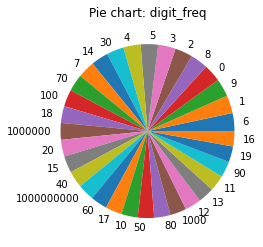

In [ ]:
#Data preparation

labels = pd.read_csv('D:/MLEnd/trainingMLEnd.csv')
labels = labels.dropna()
digit_count = labels['digit_label'].value_counts()
digit_freq = digit_count/len(labels)
display(digit_count)

#visualization
# show the distribution of the data in terms of digit_label
plt.pie(digit_freq, labels=digit_freq.index)
plt.title('Pie chart: digit_freq')
plt.show()

Feature extraction & selection

In [ ]:
#this part for feature extraction and selection is similar with the previous basic solution
def feature_extraction(data_fe, fs):
  cfg = tsfel.get_features_by_domain()
  features = tsfel.time_series_features_extractor(cfg, data_fe, fs=fs)

  features.replace([np.inf, -np.inf], np.nan, inplace=True)
  features.fillna(features.median(), inplace=True)
  return features

# Here we add a parameter y for LDA
def features_selection(data, fs, y):

    if os.path.exists("D:/MLEnd/train_features_tsfel.csv"):
        train = pd.read_csv(r'D:/MLEnd/train_features_tsfel.csv') # loading the train data
        train = train.drop("Unnamed: 0", axis= 1)
        print('Trained features loaded!')
    else:
        train = feature_extraction(data, fs)
        train = pd.DataFrame(train)
        train.to_csv("D:/MLEnd/train_features_tsfel.csv")

    if train.shape[0] != data.shape[0]:
        train = feature_extraction(data, fs)
        train = pd.DataFrame(train)
        train.to_csv("D:/MLEnd/train_features_tsfel.csv")


    # feature selection
    
    # Remove low variance features
    selector = VarianceThreshold()
    train = selector.fit_transform(train)

    #normalizing the features data
    scaler = preprocessing.StandardScaler()
    scaler.fit(train)
    train = scaler.transform(train)
#     train.to_csv("D:/MLEnd/train_features_after_selection.csv")    write out the features after selection to a csv if need

    #apply LDA to the data
    #The fitted model is used to reduce the dimensionality of the input by projecting it to the most discriminative directions
    train = LDA(n_components=31).fit_transform(train, y) #I tried different n from 5 to 31(maximum for my features), and n=31 is the best

    return train


def getXy(files,labels_file):
    X = []
    y = []

    digit_labels = labels_file['digit_label'].to_numpy()

    ####### extract x_train as training features using TSFEL
    X_data = []
    for file in tqdm(files):
        
        fs = None # if None, fs would be 22050
        x, fs = librosa.load(file,sr=fs)
        X_data.append(x)
    X_data = np.array(X_data)
    
    ####### extract y_train
    ## show how intonation map to number of classes
    le = preprocessing.LabelEncoder()
    le.fit(digit_labels)
    y = le.transform(digit_labels)
    
    X = features_selection(X_data, fs, y) #pass y to the features_selection function to apply LDA


    return np.array(X),np.array(y)

Model

  2%|▏         | 476/20000 [00:00<00:04, 4758.77it/s]

In total file length 20000


100%|██████████| 20000/20000 [00:04<00:00, 4449.28it/s]
<ipython-input-20-1bc619351a70>:60: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  X_data = np.array(X_data)


Trained features loaded!
0
Training data size: 16000
Validation data size: 4000
Best score: 0.401
Best parameters set:
	C: 10
	gamma: 'auto'
	kernel: 'rbf'
MAE: 5.813
Training Accuracy 0.81925
Validation  Accuracy 0.41725
[[468   1   3 ...   0   3   0]
 [  0 467   0 ...   5   2   0]
 [  2   1 431 ...   0   8   2]
 ...
 [  3  10   0 ... 410   2   0]
 [  1   1   9 ...   0 416   0]
 [  1   1   2 ...   0  14 435]]
[[72  3  6 ...  2  1  0]
 [ 7 83  4 ...  2  0  0]
 [ 5  3 57 ...  0  2  0]
 ...
 [ 6  6  0 ... 48  0  0]
 [ 5  0  4 ...  0 53  2]
 [ 5  0  2 ...  0  4 74]]


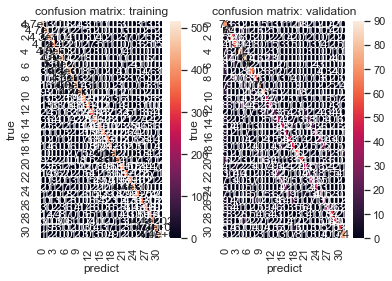

In [ ]:
def main():
#For easier to do test with different number of samples
    DEBUG = True
    number_of_sample = 20000

    ##### check out what's in the dataset
    ##I sort the audio files so that they are in sequence from 0-19999 to match the labels' sequence in trainingMLEnd.csv.
    if DEBUG == True:
        files = np.sort(glob.glob('D:/MLEnd/Training/*.wav'))[:number_of_sample]
    else:
        files = np.sort(glob.glob('D:/MLEnd/Training/*.wav'))
    print(f'In total file length {len(files)}')

    ##### Loading label from csv files
    labels = pd.read_csv('D:/MLEnd/trainingMLEnd.csv')

    ###### Get features and labels
    X_all, y_all = getXy(files, labels)

    if DEBUG == True:
        y_all = y_all[:number_of_sample]
        d = Counter(y_all)
        d_s = sorted(d.items(),key=lambda x:x[1],reverse=True)

    # If nan sample, remove them
    if np.sum(np.isnan(X_all)):
        idx = np.isnan(X_all).sum(1)>0
        X_all = X_all[~idx]
        y_all = y_all[~idx]
    print(np.sum(np.isnan(X_all)))


    ## devide all data to training and validation datasets
    from sklearn.model_selection import train_test_split
    #shuffle is True to make sure we split the dataset randomly
    X_train, X_val, y_train, y_val = train_test_split(X_all,y_all,test_size=0.2, shuffle=True)
    print(f'Training data size: {X_train.shape[0]}')
    print(f'Validation data size: {X_val.shape[0]}')


    

    def print_best_score(gsearch,param_test):
         # output best score
        print("Best score: %0.3f" % gsearch.best_score_)
        print("Best parameters set:")
        # display the best parameters this classifier used
        best_parameters = gsearch.best_estimator_.get_params()
        for param_name in sorted(param_test.keys()):
            print("\t%s: %r" % (param_name, best_parameters[param_name]))


#     SVM. I use Grid Search method to try different combinations of these three parameters: kernel, C, gamma:
#     parameters = {
#                     'kernel':['rbf'],
#                     'C':[0.1, 1, 10, 100],
#                     'gamma':['auto','scale'],
#                     }
#     I use 4000 samples to run the test and it returns the best parameters: kernel=rbf, C=10, gamma=auto.
#     So I apply these parameters on my final model to run all the 20000 data
#     Also, after running 5 times the result is MAE=5.85, training accuracy=0.82, validation accuracy=0.43

    #### SVM
    from sklearn import svm
    model = svm.SVC()
    parameters = {
                    'kernel':['rbf'],
                    'C':[10],
                    'gamma':['auto'],
                    }

    from sklearn.model_selection import GridSearchCV
    gsearch = GridSearchCV( model , param_grid = parameters, cv=5 )
    gsearch.fit( X_train, y_train)
    # gsearch.grid_scores_, gsearch.best_params_, gsearch.best_score_
    print_best_score(gsearch,parameters)

    #
    yt_p = gsearch.predict(X_train)
    yv_p = gsearch.predict(X_val)

    print(f'MAE: {metrics.mean_absolute_error(y_val, yv_p)}')
    print('Training Accuracy', np.mean(yt_p==y_train))
    print('Validation  Accuracy', np.mean(yv_p==y_val))


    #Visualization: confusion matrix
    sns.set()
    fig, (ax1, ax2) = plt.subplots(1, 2)
    C_train= confusion_matrix(y_train, yt_p, labels=np.linspace(0, 31, 32, endpoint=True, retstep=False, dtype=int))
    C_val= confusion_matrix(y_val, yv_p, labels=np.linspace(0, 31, 32, endpoint=True, retstep=False, dtype=int))
    print(C_train)
    print(C_val)

    sns.heatmap(C_train,annot=True,ax=ax1) #heat map for training set
    sns.heatmap(C_val,annot=True,ax=ax2) ##heat map for validation set
    
    ax1.set_title('confusion matrix: training') #title
    ax1.set_xlabel('predict') #x axis
    ax1.set_ylabel('true') #y axis
    
    ax2.set_title('confusion matrix: validation')
    ax2.set_xlabel('predict')
    ax2.set_ylabel('true')

if __name__ == '__main__':
    main()

#Conclusion:
The most work I did in this part is similar with the previous part. The main differences focus on feature selection and model tunning.

For tunning, I still use grid search to get the best parameters set. And the best value of C=10 is different from the model in basic part.

For feature collection, at first I use the totally same code from basic solution. But the validation accuracy is incredible low, only 15%~20%.

Then I try to apply LinearDiscriminantAnalysis(LDA) to transform features. The accuracy get a significant improvement.

For now my SVM model with parameters C=10, kernel='rbf', gamma='auto' has the average trainning accuracy=0.82, validation accuracy=0.42.

It's not good enough because the validation accuracy is not ideal. Although it's already twice greater than the previous model.

# In addition...

Near the deadline, I'm considering another usage of the dataset which is to 
build a model that can identify the gender of the speakers.

I choose to use K-means to build a unsupervised learning model and for validation I manually marked the first **200 samples** with 0 for male, 1 for female, -1 for the rest samples.

Only 200 samples, so the accuracy is not important.
Just a try after the required two parts.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os, sys, re, pickle, glob
import urllib.request
import zipfile

#from IPython.display import Audio
# import IPython.display as ipd
from tqdm import tqdm
import librosa
# drive.mount('/content/drive')

import tsfel ### time series data lib for feature extraction
from sklearn.feature_selection import VarianceThreshold
from sklearn import preprocessing
from sklearn import metrics
from collections import Counter

In [ ]:
# The modified csv file shows below:
sex_labels = pd.read_csv('D:/MLEnd/label_with_sex.csv')
display(sex_labels.head(20))

,File ID,digit_label,participant,intonation,sex
0,0000000.wav,4,S73,question,0
1,0000001.wav,2,S88,excited,0
2,0000002.wav,70,S5,neutral,0
3,0000003.wav,2,S85,bored,0
4,0000004.wav,4,S30,excited,0
5,0000005.wav,10,S55,question,1
6,0000006.wav,2,S136,neutral,0
7,0000007.wav,50,S171,bored,0
8,0000008.wav,30,S41,bored,0
9,0000009.wav,1,S29,excited,1


In [ ]:
def feature_extraction(data_fe, fs):
    cfg = tsfel.get_features_by_domain()
    features = tsfel.time_series_features_extractor(cfg, data_fe, fs=fs)
    features.replace([np.inf, -np.inf], np.nan, inplace=True)
    features.fillna(features.median(), inplace=True)

    return features


def features_selection(data, fs):


    if os.path.exists("D:/MLEnd/train_features_tsfel.csv"):
        train = pd.read_csv(r'D:/MLEnd/train_features_tsfel.csv') # loading the train data
        # train = train[['Unnamed: 0','0_Wavelet energy_0', '0_Wavelet energy_1', '0_Wavelet energy_2', '0_Wavelet energy_3']]
        # print(list(train.columns))
        train = train.drop("Unnamed: 0", axis= 1)
        print('Trained features loaded!')
    else:
        train = feature_extraction(data, fs)
        train = pd.DataFrame(train)
        train.to_csv("D:/MLEnd/train_features_tsfel.csv")

    if train.shape[0] != data.shape[0]:
        train = feature_extraction(data, fs)
        train = pd.DataFrame(train)
        train.to_csv("D:/MLEnd/train_features_tsfel.csv")

    # feature selection
    # Remove low variance features
    selector = VarianceThreshold()
    train = selector.fit_transform(train)

    #normalizing the data
    scaler = preprocessing.StandardScaler()
    scaler.fit(train)
    train = scaler.transform(train)

    return train



def getXy(files,labels_file):
    X = []
    y = []


    sex_labels = labels_file['sex'].to_numpy()

    ###### extract x_train as training features using TSFEL
    X_data = []
    for file in tqdm(files):
        fs = None # if None, fs would be 22050
        x, fs = librosa.load(file,sr=fs)
        X_data.append(x)
    X_data = np.array(X_data)
    X = features_selection(X_data, fs)

    ####### extract y_train

    y = sex_labels

    return np.array(X),np.array(y), X_data




def main():

    DEBUG = True
    number_of_sample = 20000

    if DEBUG == True:
        files = np.sort(glob.glob('D:/MLEnd/Training/*.wav'))[:number_of_sample]
    else:
        files = np.sort(glob.glob('D:/MLEnd/Training/*.wav'))
    print(f'In total file length {len(files)}')


    ##### Loading label from csv files
    labels = pd.read_csv('D:/MLEnd/label_with_sex.csv')

    ###### Get features and labels
    X_all, y_all, X_raw = getXy(files, labels)
    X_all = X_all[:200,:]
    y_all = y_all[:,np.newaxis][:200,:]

    if DEBUG == True:
        y_all = y_all[:number_of_sample,0]
        d = Counter(y_all)
        d_s = sorted(d.items(),key=lambda x:x[1],reverse=True)
        print(d_s)


    # If nan sample, remove them
    if np.sum(np.isnan(X_all)):
        idx = np.isnan(X_all).sum(1)>0
        X_all = X_all[~idx]
        y_all = y_all[~idx]
    print(np.sum(np.isnan(X_all)))



    ## devide all data to training and validation datasets
    from sklearn.model_selection import train_test_split
    X_train, X_val, y_train, y_val = train_test_split(X_all,y_all,test_size=0.3, shuffle=True)
    print(f'Training data size: {X_train.shape[0]}')
    print(f'Validation data size: {X_val.shape[0]}')

    # X_train = X_all
    # X_val = X_all[:200,:]
    #
    # # y_train = y_all[200:,:]
    # y_val = y_all[:,np.newaxis][:200,:]

    ######## Classifiers

    from sklearn.cluster import KMeans
    print('--------------kmeans--------------')
    kmeans = KMeans(n_clusters=2, random_state=0, n_jobs=-1).fit(X_train)
    yt_p = kmeans.predict(X_train)
    yv_p = kmeans.predict(X_val)
    print('Training Accuracy', np.mean(yt_p==y_train))
    print('Validation  Accuracy', np.mean(yv_p==y_val))

    ###### visulization
    # from sklearn.manifold import TSNE
    # tsne = TSNE(n_components=2)
    # tsne.fit_transform(X_train)
    # visul_ = tsne.embedding_


    ####
    from sklearn.neighbors import KNeighborsClassifier
    ##### KNN
    print('--------------KNN--------------')
    kn = 5 ## 0.76.0.63
    print(f'{kn}')
    print('prediction')
    modelKNN_sbp = KNeighborsClassifier(n_neighbors= kn,
                                        # weights='distance',
                                        # algorithm='kd_tree',
                                        # metric='mahalanobis',
                                        # metric_params={'V': np.cov(X_train.T)},
                                        n_jobs=-1 ).fit(X_train, y_train)
    train_y_pred = modelKNN_sbp.predict(X_train)
    test_y_pred = modelKNN_sbp.predict(X_val)
    print(f'MAE: {metrics.mean_absolute_error(y_val, test_y_pred)}')
    print('Training Accuracy', np.mean(train_y_pred==y_train))
    print('Validation  Accuracy', np.mean(test_y_pred==y_val))


    #### LR
    # from sklearn.metrics.pairwise import check_pairwise_arrays
    # from scipy.linalg import cholesky
    # from sklearn.linear_model import LogisticRegression
    #
    # def anova_kernel(X, Y=None, gamma=None, p=1):
    #     X, Y = check_pairwise_arrays(X, Y)
    #     if gamma is None:
    #         gamma = 1. / X.shape[1]
    #
    #     diff = X[:, None, :] - Y[None, :, :]
    #     diff **= 2
    #     diff *= -gamma
    #     np.exp(diff, out=diff)
    #     K = diff.sum(axis=2)
    #     K **= p
    #     return K
    #
    # # Kernel matrix based on X matrix of all data points
    # K = anova_kernel(X_train)
    # R = cholesky(K, lower=False)
    #
    # clf = LogisticRegression(n_jobs=-1,solver='saga').fit(R(X_train),y_train)
    # train_y_pred = clf.predict(R(X_train))
    # test_y_pred = clf.predict(R(X_val))
    # print('Training Accuracy', np.mean(train_y_pred==y_train))
    # print('Validation  Accuracy', np.mean(test_y_pred==y_val))
    #
    
    
    #### SVM
    from sklearn import svm
    # model = svm.SVC()
    # parameters = {
    #                 'kernel':['poly', 'rbf', 'sigmoid'],
    #                 'C':[0.1, 1, 5, 10, 100],
    #                 'gamma':['auto','scale'],
    #                 }
    #
    # from sklearn.model_selection import GridSearchCV
    # gsearch = GridSearchCV( model , param_grid = parameters, cv=2 )
    # gsearch.fit( X_train, y_train)
    # # gsearch.grid_scores_, gsearch.best_params_, gsearch.best_score_
    # print_best_score(gsearch,parameters)

    model = svm.SVC(kernel='rbf', C=5, gamma='auto')
    model.fit(X_train,y_train)

    yt_p = model.predict(X_train)
    yv_p = model.predict(X_val)
    
    print('--------------SVM--------------')
    print('kernel=rbf, C=5, gamma=auto')
    print('Training Accuracy', np.mean(yt_p==y_train))
    print('Validation  Accuracy', np.mean(yv_p==y_val))



if __name__ == '__main__':
    main()

  5%|▍         | 953/20000 [00:00<00:04, 4735.95it/s]

In total file length 20000


100%|██████████| 20000/20000 [00:04<00:00, 4518.85it/s]
<ipython-input-9-08a17bca328b>:61: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  X_data = np.array(X_data)


Trained features loaded!
[(0, 117), (1, 83)]
0
Training data size: 140
Validation data size: 60
--------------kmeans--------------
Training Accuracy 0.5785714285714286
Validation  Accuracy 0.6
--------------KNN--------------
5
prediction
MAE: 0.36666666666666664
Training Accuracy 0.7642857142857142
Validation  Accuracy 0.6333333333333333
--------------SVM--------------
kernel=rbf, C=5, gamma=auto
Training Accuracy 0.9285714285714286
Validation  Accuracy 0.7166666666666667


D:\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:938: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
